In [17]:
import seqlogo
import logomaker
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
sys.path.append("/home/e_takla/WORK/code") 

from dataloading.feature_engineering import dummy_func, separate_elemets
from dataloading import train_test_splits
from dataloading.dataloading import create_tf_ds, load_and_create_dictionary
from dataloading.tf_dataloaders import  DNA_tf_dl
from dataloading.feature_engineering import dummy_func, separate_elemets
from dataloading import train_test_splits
from dataloading.tf_dataloaders import  DNA_tf_dl
from modeling.tf.models import create_multioutput_model
import tensorflow as tf
import h5py
import json

from io import StringIO
from functools import partial

from modeling.tf.models import create_multioutput_model

import pandas as pd
from tensorflow import keras
import tensorflow as tf

from keras import backend as K

# these functions are important in order to load the model, keras needs to know all dependencies used in
# training
def recall_m(y_true, y_pred):
    """
    https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
    There is a slight deviation between this calculation and the builtin one (3rd decimal point)
    For now I am keeping it as the F1 score is very near the true and is useful enough for HPS search, however
    I should implement a more correct version
    TODO: Do it with a more straghtforward one, where you compare y_pred to 0.5 and then check equality
    to y_true
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



# Definitions needed to load the model and eval dataset

Eval dataset will be used to identify the motifs that a certain conv filter identifies

In [7]:
chroms_lens = """
chrom,size
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
X,155270560
8,146364022
9,141213431
10,135534747
11,135006516
12,133851895
13,115169878
14,107349540
15,102531392
16,90354753
17,81195210
18,78077248
20,63025520
Y,59373566
19,59128983
22,51304566
21,48129895
"""

chrom_len_dfs = pd.read_csv(StringIO(chroms_lens))
chroms_lens_dict = chrom_len_dfs.set_index('chrom').to_dict()['size']


def get_dataset_config(dataset_full_name, chroms_to_use):
    dataset_config = {'dataset_name':dataset_full_name, 
                      'chroms_lens_dict':chroms_lens_dict,
                      'chroms_to_use':chroms_to_use
                      }
    return dataset_config


def get_train_test_split_config(strategy, random_seed):
    train_test_split_config = {
                                #whole_chroms, partial_chrom_contig, partial_chrom_random, by_random
                                   'strategy':strategy, #'partial_chrom_contig',
                                 #if strategy is by_whole_chrom, it's a list. Else, a float between 0 and 1 and must add up to 1
                                   'train':0.6, 
                                   'val':0.2,
                                   'test':0.2,
                                   'random_seed':random_seed
                              }
    return train_test_split_config

def get_data_io_config(input_keys, chroms_to_use, use_rev_compl, output_name, batch_size):
    #seq is mandatory
    X_transform_dict = {'seq': partial(tf.one_hot, depth=4)}
    
    #Add the optional inputs
    if 'chrom_idx' in input_keys:
        X_transform_dict['chrom_idx'] = partial(tf.one_hot, depth=23 )#len(chroms_to_use))
    if 'midpoint' in input_keys:
        X_transform_dict['midpoint'] = dummy_func
    
    data_io_config = {
                          #'use_seq_as_input':True, #This one is assumed by default
                          'use_rev_compl_as_input':use_rev_compl,
                          'input_keys':input_keys,
                          'output_keys':['out'],
                          'separate_outputs':{'out':output_name}, #MAKE THIS 
                          'index_keys':['chrom_idx', 'index', 'ex_type', 'ds_index'],
                          'X_transform_dict':X_transform_dict,
                          'y_transform_dict':{o: dummy_func for o in output_name},
                          'batch_size':batch_size,
                          'shuffle_train':True,
                          'shuffle_val':False,
                          'shuffle_test':False,
                     }
    return data_io_config




def get_model_config(output_name, seq_len, chrom_idx, midpoint, data_io_config):
    hparams_dict = {}

    hparams_dict['first_cnn_filter_size'] = 30
    hparams_dict['first_cnn_n_filters']   = 20   
    hparams_dict['first_cnn_pool_size_strides']   = 15

    hparams_dict['n_convs'] = 1
    hparams_dict['n_convs_dilation'] = 1
    hparams_dict['n_convs_filter_size']  = 3
    hparams_dict['n_convs_n_filters']    = 15
    hparams_dict['n_convs_pool_size_stride']    = 10
    #hparams_dict['n_convs_pool_strides'] = 10

    hparams_dict['fc_activations'] = tf.keras.activations.selu#'elu'
    
    hparams_dict['use_GRU'] = False
    hparams_dict['n_gru'] = 1
    hparams_dict['gru_hidden_size'] = 50

    hparams_dict['first_fcc_size'] = 250
    hparams_dict['n_fccs'] = 1
    hparams_dict['fccs_size'] = 400
    hparams_dict['seq_len'] = seq_len


    hparams_dict['dropout_type'] = "normal" #make it mc to become mc dropout
    hparams_dict['dropout_rate'] = 0.15

    hparams_dict['lr'] = 0.002#0.0004

    hparams_dict['outputs_separate_fc'] = [250]

    hparams_dict['n_outputs'] = 1
    hparams_dict['outputs_names'] = output_name if isinstance(output_name, list) else [output_name]
    
    inputs_dict = {
                    'seq': {'type':'normal', 
                            'dim':(seq_len, 4) },
                    'seq_rc':{'type':'normal', 
                              'dim':(seq_len, 4) }
                  }
    if chrom_idx == True:
        #dims here is 1 hot size, embedding size
        inputs_dict['chrom_idx'] = {'type':'embedding', 
                                    'dim':(23, 2) }
    if midpoint == True:
        inputs_dict['midpoint'] = {'type':'normal', 
                                   'dim':(1,) }
    
    model_config = {
                        'bayesian_epistemic':False,
                        'bayesian_aleatoric':False,
                        'inputs':inputs_dict,
                        'outputs':{o:{'loss':'binary_crossentropy', 'weight':1} for o in output_name},
                        'data_config':data_io_config, #Used to know the model's input
                        'hp_dict':hparams_dict
    #                     'model_hparams_dict':hparams_dict
                   }
    
    if (chrom_idx == True) and (midpoint == True):
        model_config['embed_seq_loc'] = {'dim':2}
    
    return model_config


def get_k_fold_params(n_folds, train_perc, random_seed):
    k_fold_params = {
                        'n_folds':n_folds,
                        'train_perc':train_perc,
                        'test_perc':1-train_perc,
                        'random_seed':random_seed
                    }
    return k_fold_params


def get_negexamples_config(strtgy_0_prop,
                           strtgy_1_prop,
                           strtgy_2_prop,
                           strtgy_3_prop,
                           shuffle_pos_prop,
                           ):
    negexamples_config = {
                            0:strtgy_0_prop,
                            1:strtgy_1_prop,
                            2:strtgy_2_prop,
                            3:strtgy_3_prop,
                            'shuffle_pos':shuffle_pos_prop
                         }
    return negexamples_config

output_name = ["AA1"]#"AA1" #A_hotspots_intersectC_hotspots_seqlen
fname_prefix = "".join(output_name)
seq_len = 2000
chrom_idx = True
midpoint = True
test2_interval = 10
random_seed = 123
batch_size = 128
use_rev_compl = True
n_folds = 3
train_perc = 0.6
epochs = 10

chroms_to_use = list(range(1,23))
use_x_y = True
if use_x_y:
    chroms_to_use += ['X', 'Y']

fold_fn_name = 'partial_chrom_shuffled' #'whole_genome_shuffled_k_fold'

ds_root = "./"
if ds_root == "./":
    ds_root = os.getcwd()

dataset_local_name = f"{fname_prefix}_seqlen={seq_len}_multnegs.h5"
ds_path = os.path.join(ds_root, dataset_local_name)

# negexamples_config = {'strtgy_0_prop':0.2,
#                       'strtgy_1_prop':0.2,
#                       'strtgy_2_prop':0.2,
#                       'strtgy_3_prop':0.2,
#                       'shuffle_pos_prop':0.2}

input_keys = ['seq']
if midpoint:
    input_keys.append('midpoint')
if chrom_idx:
    input_keys.append('chrom_idx')
    
negexamples_config = {(1000,5000):1.0}

dataset_config = get_dataset_config(dataset_full_name=ds_path,
                                    chroms_to_use=chroms_to_use)

train_test_split_config = get_train_test_split_config(strategy=fold_fn_name,
                                                      random_seed=random_seed)

data_io_config = get_data_io_config(input_keys=input_keys,
                                    chroms_to_use=chroms_to_use,
                                    use_rev_compl=use_rev_compl,
                                    output_name=output_name,
                                    batch_size=batch_size)

model_config = get_model_config(output_name=output_name,
                                chrom_idx=chrom_idx, 
                                midpoint=midpoint,
                                seq_len=seq_len,
                                data_io_config=data_io_config)

k_fold_params = get_k_fold_params(n_folds=n_folds,
                                  train_perc=train_perc,
                                  random_seed=random_seed)


# Read the data and create the datasets
X_transform_dict = data_io_config['X_transform_dict']
y_transform_dict = data_io_config['y_transform_dict']
batch_size = data_io_config['batch_size']
shuffle_train = data_io_config['shuffle_train']
shuffle_val = data_io_config['shuffle_val']
shuffle_test = data_io_config['shuffle_test']
hparams_dict = model_config['hp_dict']


chroms_list = dataset_config['chroms_to_use']
input_keys = data_io_config['input_keys']
output_keys = data_io_config['output_keys']
index_keys = data_io_config['index_keys']
n_folds = k_fold_params['n_folds']
train_perc = k_fold_params['train_perc']
test_perc = k_fold_params['test_perc']
random_seed = k_fold_params['random_seed']

f = h5py.File(dataset_config['dataset_name'], 'r')
metadata = json.loads(f['/'].attrs["metadata"])
f.close()

rev_com_dict_str = metadata['num_reverse_compliment_dict']
rev_com_dict = {int(k): v for k, v in rev_com_dict_str.items()}

use_rc = data_io_config['use_rev_compl_as_input']
if use_rc:
    add_rc = rev_com_dict
else:
    add_rc = None

    
data_dict = load_and_create_dictionary(dataset_config, data_io_config, negexamples_config, 'train')

data_dict, test2_dict = train_test_splits.train_val_split_dicts_by_interval(data_dict,
                                                                            input_keys,
                                                                            output_keys,
                                                                            index_keys,
                                                                            test2_interval)


test2_ds = DNA_tf_dl(X_dict=test2_dict['input'],
                        X_transform_dict=X_transform_dict,
                        y_dict=test2_dict['output'],
                        y_transform_dict=y_transform_dict,
                        rev_comp_dict=add_rc,
                        batch_size=batch_size,
                        shuffle=False,
                        reshuffle_on_epoch_end=False)



File /home/e_takla/WORK/scratchpad/AA1_seqlen=2000_multnegs.h5 was successfully opened


File opened. Found the following Folds:
['test', 'train']


Fold folder opened. Found the following datasets:
['chr_10_neg_(1000, 5000)_meta', 'chr_10_neg_(1000, 5000)_seq', 'chr_10_neg_(10000, 20000)_meta', 'chr_10_neg_(10000, 20000)_seq', 'chr_10_neg_(20000, 100000)_meta', 'chr_10_neg_(20000, 100000)_seq', 'chr_10_neg_(5000, 10000)_meta', 'chr_10_neg_(5000, 10000)_seq', 'chr_10_pos_meta', 'chr_10_pos_out', 'chr_10_pos_seq', 'chr_11_neg_(1000, 5000)_meta', 'chr_11_neg_(1000, 5000)_seq', 'chr_11_neg_(10000, 20000)_meta', 'chr_11_neg_(10000, 20000)_seq', 'chr_11_neg_(20000, 100000)_meta', 'chr_11_neg_(20000, 100000)_seq', 'chr_11_neg_(5000, 10000)_meta', 'chr_11_neg_(5000, 10000)_seq', 'chr_11_pos_meta', 'chr_11_pos_out', 'chr_11_pos_seq', 'chr_12_neg_(1000, 5000)_meta', 'chr_12_neg_(1000, 5000)_seq', 'chr_12_neg_(10000, 20000)_meta', 'chr_12_neg_(10000, 20000)_seq', 'chr_12_neg_(20000, 100000)_me

/home/e_takla/WORK/code/dataloading/dataloading.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_dict['ex_type'] = np.array(example_set_index)


3008 1577.0
GETTING META chr_4_neg_(1000, 5000)_meta


3154 Training examples generated for chrom 4
	1577 positive, 1577 negative
GETTING META chr_5_pos_meta
2703 1423.0
GETTING META chr_5_neg_(1000, 5000)_meta


2846 Training examples generated for chrom 5
	1423 positive, 1423 negative
GETTING META chr_6_pos_meta
2595 1362.0
GETTING META chr_6_neg_(1000, 5000)_meta


2724 Training examples generated for chrom 6
	1362 positive, 1362 negative
GETTING META chr_7_pos_meta
2310 1209.0
GETTING META chr_7_neg_(1000, 5000)_meta


2418 Training examples generated for chrom 7
	1209 positive, 1209 negative
GETTING META chr_8_pos_meta
2120 1120.0
GETTING META chr_8_neg_(1000, 5000)_meta


2240 Training examples generated for chrom 8
	1120 positive, 1120 negative
GETTING META chr_9_pos_meta
1818 963.0
GETTING META chr_9_neg_(1000, 5000)_meta


1926 Training examples generated for chrom 9
	963 positive, 963 negative
GETTING META chr_10_pos_meta
1865 984.0
GETTING META chr_10_neg_(1000, 5000)_meta



In [8]:
def get_conv_model(model_in, layer_idx=2):
    """
    Utility function to extract the layer of interest, and convert it to a model object so that we
    can get the activations. This greatly simplifies out code.
    """
    conv_model = tf.keras.Model(inputs=model_in.input, outputs = model_in.layers[layer_idx].output)
    return conv_model

def get_conf_predictions(model_in, dataset, layer_idx=2):
    """
    Utlity function to get a model's activations of a specific layer. We use it to get 
    """
    conv_model = get_conv_model(model_in, layer_idx)
    return conv_model.predict(dataset) #, steps = 1) # predict_generator is deprecated


In [9]:
dependencies = {
                    'recall_m': recall_m,
                    'precision_m': precision_m,
                    'f1_m': f1_m
                }
# I saved a model and loading it from the hard disk. You can do the same on the other notebook I gave
# Just retrain the model, then at the end call `model.save('2022_olivier_model.h5')`
model = keras.models.load_model('2022_olivier_model.h5', custom_objects=dependencies)

To understand, let's inspect the model layers

In [10]:
for i, in_layer in enumerate(model.layers):
    print("\t", i, in_layer.name)

	 0 seq
	 1 seq_rc
	 2 shared_first_conv
	 3 direct_path_first_max_pool
	 4 reverse_path_first_max_pool
	 5 direct_path_first_drop_out
	 6 reverse_path_first_drop_out
	 7 n_convs_1_conv
	 8 direct_path_n_convs_1_max_pool
	 9 reverse_path_n_convs_1_max_pool
	 10 chrom_idx
	 11 direct_path_n_convs_1_drop_out
	 12 reverse_path_n_convs_1_drop_out
	 13 chrom_emb
	 14 midpoint
	 15 add
	 16 concatenate
	 17 flatten
	 18 seq_loc_embd
	 19 concatenate_1
	 20 batch_normalization
	 21 first_fcc
	 22 activation
	 23 batch_normalization_1
	 24 first_fcc_drop_out
	 25 fcc_1
	 26 activation_1
	 27 batch_normalization_2
	 28 fcc_1_drop_out
	 29 AA1_raw_0
	 30 activation_2
	 31 AA1_separate_fc_1_drop_out
	 32 AA1_logit
	 33 AA1


Conv layer with PWM is layer number 2

We get the conv layer and convert to a Keras model, and ask it to predict one of our dataset. In this code we are using test2, but we can argue for using something else, like the trainingset instead or even all the datasets.



In [11]:
conv_model = get_conv_model(model, layer_idx=2)
out = conv_model.predict(test2_ds)

Output is the activation map of the convolution! It should be mostly zeros except where there is a DNA stretch that matches our conv filter.

Dimension is number_of_examples x seq_length x n_filters

In [12]:
out.shape

(5073, 1971, 20)

In [16]:
# Let us check the 3rd filter if it has any matches for example in the first 100 bps
first_n_examples = 10
n_bps_to_check = 100
filter_number = 2
out[:first_n_examples, :n_bps_to_check, filter_number]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

Filter activations are low (mostly zeros, besides things are normalized anyway). Just to gain intuition, let's check it:

In [19]:
filters_avg = out.mean(axis=1).mean(axis=0)
filters_avg

array([6.9744204e-04, 8.8833491e-05, 8.0025783e-03, 5.7706592e-04,
       6.0633998e-03, 1.2710954e-04, 1.0377644e-02, 5.2382272e-02,
       2.0645490e-04, 1.2425333e-04, 4.6943969e-04, 3.7904960e-04,
       5.1334995e-04, 7.7833171e-04, 3.6857478e-04, 0.0000000e+00,
       4.1126463e-04, 4.8265568e-04, 8.8748777e-05, 5.1508280e-03],
      dtype=float32)

Compute threshold for significant activation. Two standard deviations away to make things simpler

In [20]:
filters_std = out.std(axis=1).std(axis=0)
filter_thresh_2st = filters_avg + 2*(filters_std)

In [21]:
def get_filter_hit_seqs(dataset, activation_out, filter_id, ordered_bps="ACTG"):
    """
    FUNCTION used to get the sequences at positions that have a positive activation
    """
    original_len = dataset.X_dict['seq'][0].shape[0]
    actv_len = activation_out[0, :, 0].shape[0]
    filter_size = original_len - actv_len + 1
    substitution_dict = {i:v for i, v in enumerate(("ACTG"))}
    print(f"Computed filter size is {filter_size}")
    
    seqs = []
    for i in range(activation_out.shape[0]):
        if i%1000 == 0:
            print(f"Reached example {i}")
        # Out should be a 3D array of n_example x seq_len x n_filters
        example_actv = activation_out[i, :, filter_id]
        actv_idx = np.nonzero(example_actv)[0]
        
        orgl_seq_start = actv_idx #actv_idx - (filter_size//2)
        orgl_seq_end = actv_idx + filter_size#actv_idx + (filter_size//2)
        
        #both are start and end array, loop over them
        for start, end in zip(orgl_seq_start, orgl_seq_end):
            seq = dataset.X_dict['seq'][i][start:end]
            if len(seq) != filter_size:
                print(i, actv_idx, start, end)
            else:
                seqs.append("".join([substitution_dict[bp] for bp in seq]))
    return seqs

In [22]:
filter_hits_seqs = get_filter_hit_seqs(test2_ds, out, 19)

Computed filter size is 30
Reached example 0
Reached example 1000
Reached example 2000
Reached example 3000
Reached example 4000
Reached example 5000


Returned value is a list of sequences

In [23]:
filter_hits_seqs[0]

'TTCAGCACCCATCTCTGGGCCCAGAATGAC'

In [25]:
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import motifs

Multiple sequence alignment of hits

In [26]:
biopy_seqs = [Seq(s) for s in filter_hits_seqs]
m = motifs.create(biopy_seqs)
print(m.counts)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29
A: 54372.00 53316.00 43172.00 101920.00 81826.00 96733.00 66283.00 82263.00 59723.00 54585.00 102675.00 66892.00 86922.00 71998.00 91112.00 51317.00 89417.00 131153.00 31452.00 83990.00 58192.00 82000.00 59825.00 14379.00 47545.00 114375.00 125285.00 67186.00 48807.00 81912.00
C: 44570.00 90808.00 118928.00 75264.00 57193.00 51590.00 61442.00 91030.00 81408.00 100553.00 47112.00 21830.00 69038.00 70094.00 63548.00 149448.00 83875.00 18343.00 60447.00 100565.00 90863.00 37395.00 35974.00 37717.00 104303.00 115820.00 28482.00 35917.00 104345.00 83000.00
G: 93599.00 51475.00 50081.00 29308.00 83496.00 62072.00 90501.00 69235.00 33326.00 40209.00 30935.00 67275.00 76805.00 51600.00 54603.00 45525.00 36384.00 39225.00 144630.00 30946.00 20731.00 101462.00 112552.00 150860.00 69268.

Inspect the count

In [27]:
pd.DataFrame(m.counts)

,A,C,G,T
0,54372,44570,93599,76951
1,53316,90808,51475,73893
2,43172,118928,50081,57311
3,101920,75264,29308,63000
4,81826,57193,83496,46977
5,96733,51590,62072,59097
6,66283,61442,90501,51266
7,82263,91030,69235,26964
8,59723,81408,33326,95035
9,54585,100553,40209,74145


Now, we reuse everything inside a "do it all" function

In [37]:
def interpret_cnn_filter(dataset, pwm_wgts, activation_out, filter_id, weblogo_name, plt_height, title):
    """
    @param dataset: any of our dataset we will use for extracting the motif, e.g. test2_ds
    @param pwm_wgts: numpy version of *all* motifs, used for raw plotting of values
    @param activation_out: used along with @param dataset for extractng sequences that activate a filter
    @param filter_id: filter we want to plot
    @param weblogo_name: you can ignore this, I tried to extract things as svg but it's hard to work,
                         just not worth it as we can get the images from matplotlib
    @param plt_height: for aesthetics, since we stack multiple plots, controlling this can be useful
                       Note that this is the height of a single plot, whole image will this x 6
    @param title: matplotlib title
    """
    filter_hits_seqs = get_filter_hit_seqs(dataset, activation_out, filter_id)
    pwm = pwm_wgts[:,:,filter_id]
    
    # create sequences, then create alignment m
    biopy_seqs = [Seq(s) for s in filter_hits_seqs]
    m = motifs.create(biopy_seqs)
    
    print("Consensus:", m.consensus)
    print("Degenerate Consensus", m.degenerate_consensus)
    
    # Todo: make it a parameter to the function? So that we work better with platypus?
    gc = .54
    background = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    
    # get the counts matrix, weight matrix, probablity matrix, info matrix..etc. Please refer to
    # thesis for more info
    counts_mat = logomaker.alignment_to_matrix(filter_hits_seqs)
    
    weight_mat = logomaker.transform_matrix(counts_mat,
                                     background=background,            
                                     from_type='counts', 
                                     to_type='weight')
    prob_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='probability')
    info_mat = logomaker.transform_matrix(counts_mat, 
                                           from_type='counts', 
                                           to_type='information')
    
    weight_mat_centered = logomaker.transform_matrix(weight_mat, center_values=True)
    
    # Create an empty dataframe with the required columns
    df_consensus = pd.DataFrame(columns=list("ACTG"))
    # Loop over consensus and put at the correct position a 1. Note that we don't
    # want the remainder bps to be zero to avoid errors, so we init them to be a
    # very small value
    for bp in m.consensus:
        d = {'A':0.0001, 'C':0.0001, 'T':0.0001, 'G':0.0001}
        d[bp] = 1
        df_consensus = df_consensus.append(d, ignore_index=True)
        
    #iupac_alphabet = ['A', 'C', 'G', 'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N', 'T']
    #df_degenerate = pd.DataFrame(columns=iupac_alphabet)
    #for bp in m.degenerate_consensus:
    #    d = {k:0.0001 for k in iupac_alphabet}
    #    d[bp] = 1
    #    df_degenerate = df_degenerate.append(d, ignore_index=True)
    
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(20, plt_height*6) )
    
    fig.suptitle(title, fontsize=49, y=0.902)
    
    logomaker.Logo(pd.DataFrame(df_consensus, columns=list("ACTG")), ax=axs[0] )
    axs[0].set_ylabel("Consensus Sequence", fontsize=15)
    
    #logomaker.Logo(pd.DataFrame(df_degenerate, columns=list("ACTG")), ax=axs[1] )
    logomaker.Logo(pd.DataFrame(pwm, columns=list("ACTG")), ax=axs[1] )
    axs[1].set_ylabel("Convolution Filter Learned Weights", fontsize=12)
    
    logomaker.Logo(counts_mat, ax=axs[2])
    axs[2].set_ylabel("Count Matrix", fontsize=15)
    
    logomaker.Logo(weight_mat, ax=axs[3])
    axs[3].set_ylabel("Weight Matrix", fontsize=15)
    
    logomaker.Logo(prob_mat, ax=axs[4])
    axs[4].set_ylabel("Probability Matrix", fontsize=15)
    
    logomaker.Logo(info_mat, ax=axs[5])
    axs[5].set_ylabel("Information Matrix", fontsize=15)
    
    #fig.tight_layout()
    plt.show()
    
    
def get_conv_weights_as_np(model_in):
    return model_in.layers[2].get_weights()[0] #weights are list of 2, weights and biases

def draw_pwm_filter(pwm, columns=list("ACTG")):
    """
    A utility function to draw outright the full conv filters from the weights, not seq alignment
    Useful to know what's going on with each filter quickly. As you get used to the model's output,
    you'll quickly be able to recognize even partially learned motifs what they are about :)
    """
    fig, ax = plt.subplots(figsize=(15, 5) )
    logomaker.Logo(pd.DataFrame(pwm, columns=columns), ax=ax )
    plt.show()

In [35]:
pwm_wgts = get_conv_weights_as_np(model) #model.layers[1].get_weights()[0]
pwm_wgts.shape

(30, 4, 20)

### Quick and Dirty: Plot all filters just to get an idea





0


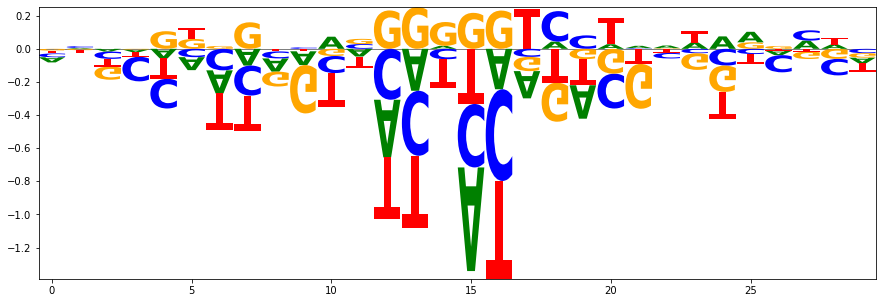





1


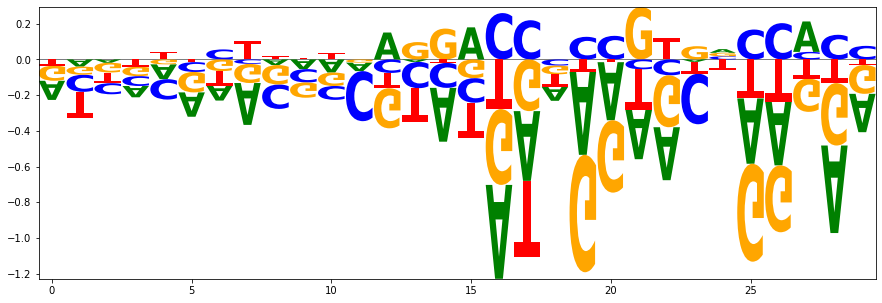





2


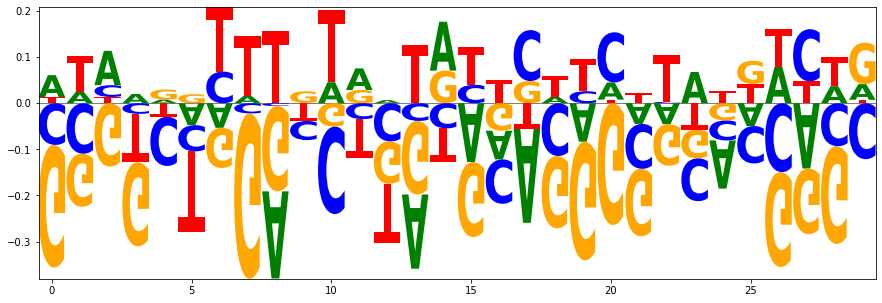





3


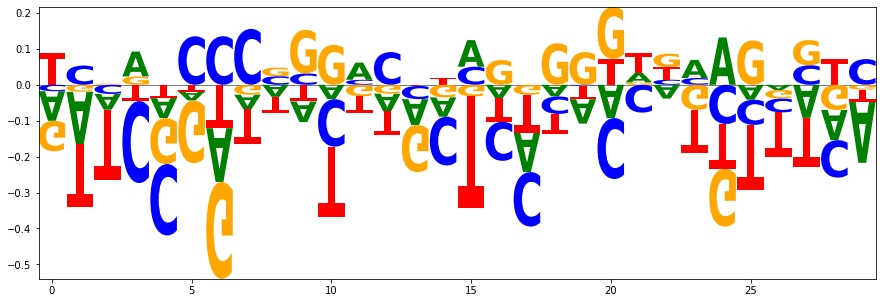





4


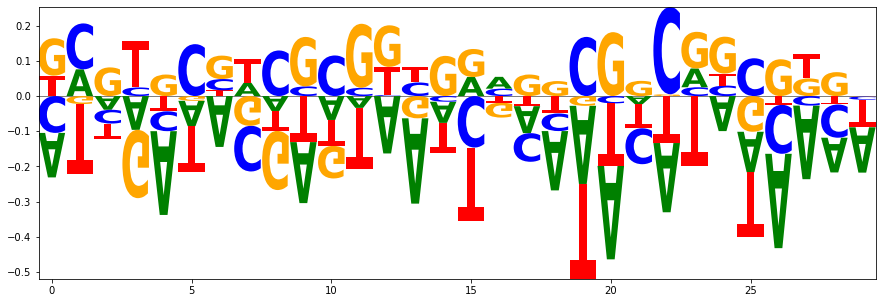





5


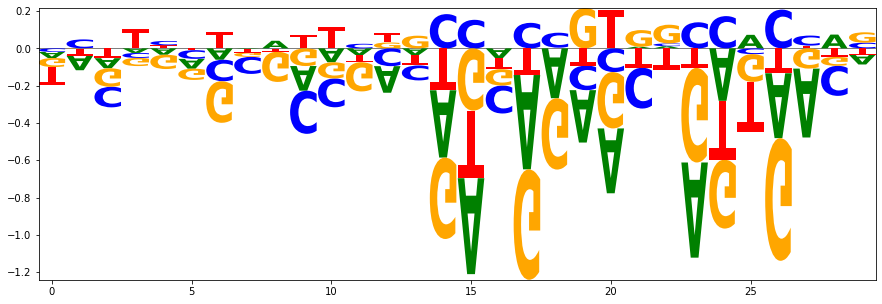





6


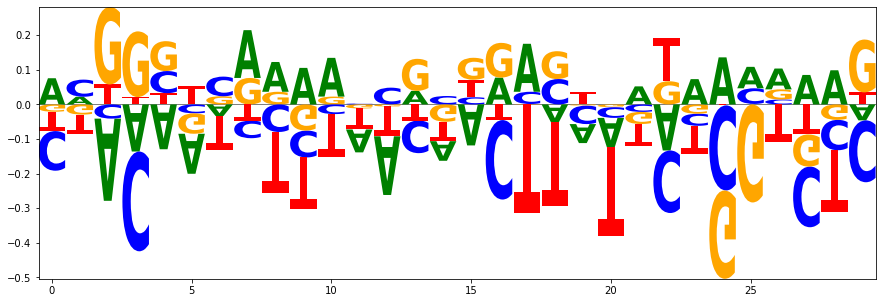





7


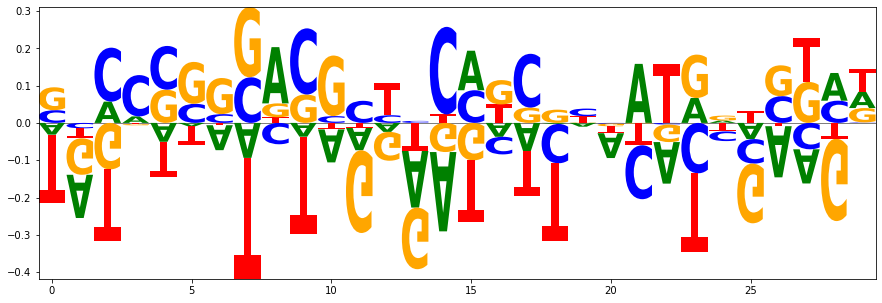





8


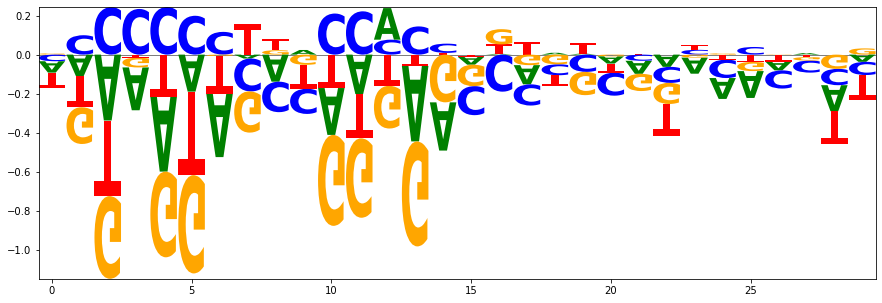





9


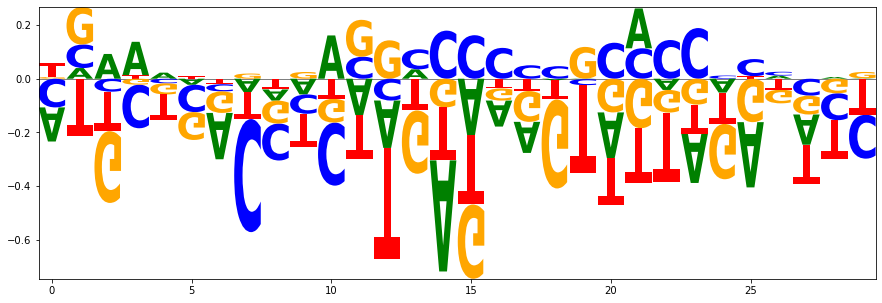





10


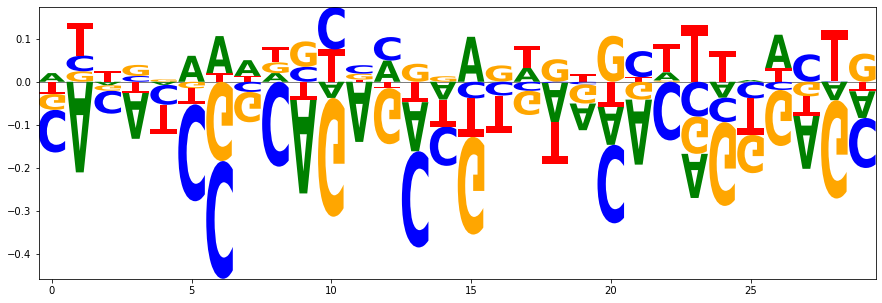





11


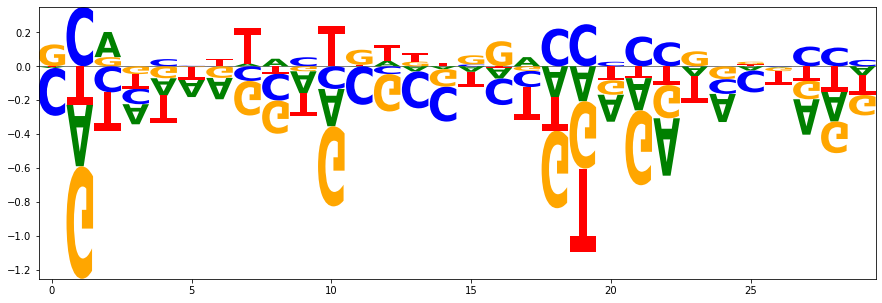





12


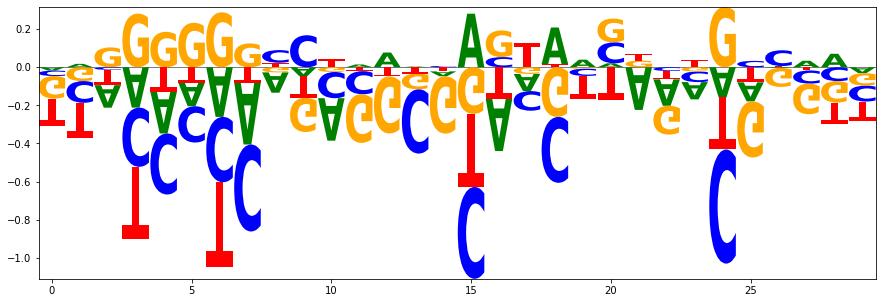





13


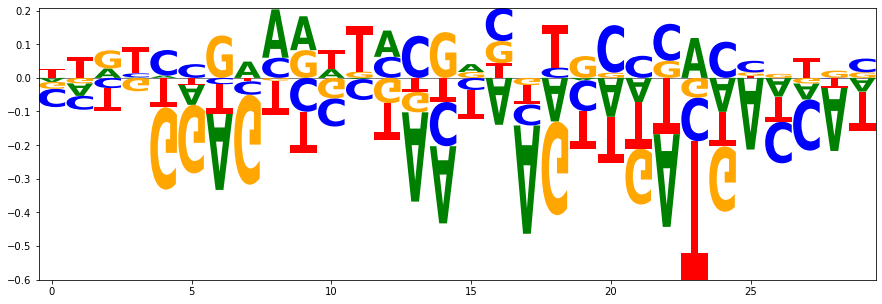





14


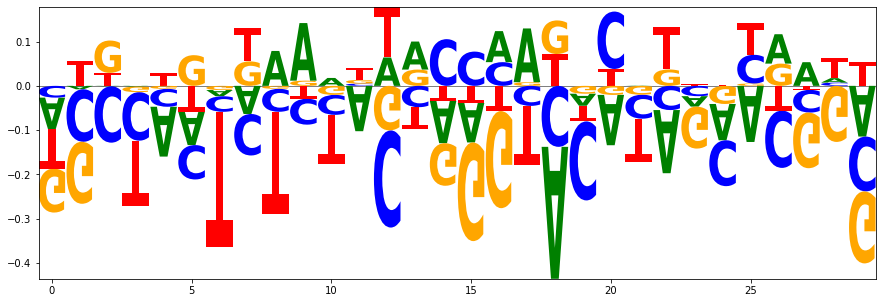





15


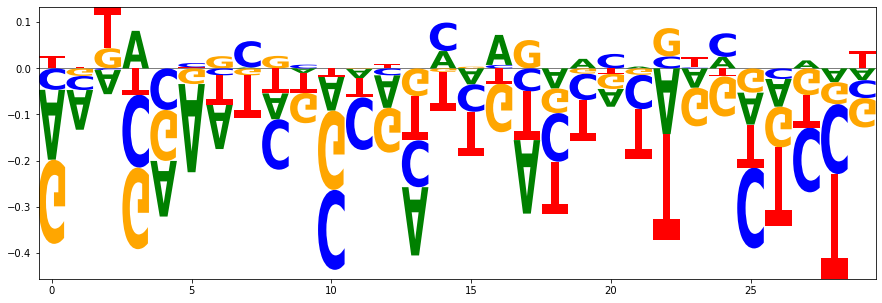





16


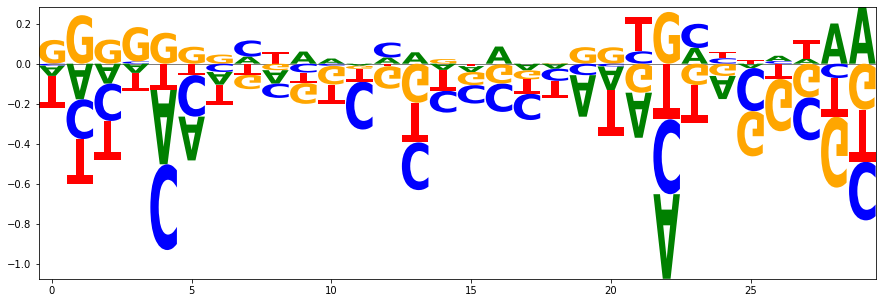





17


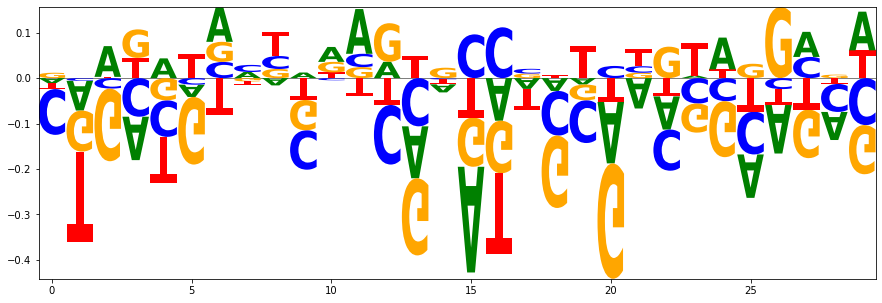





18


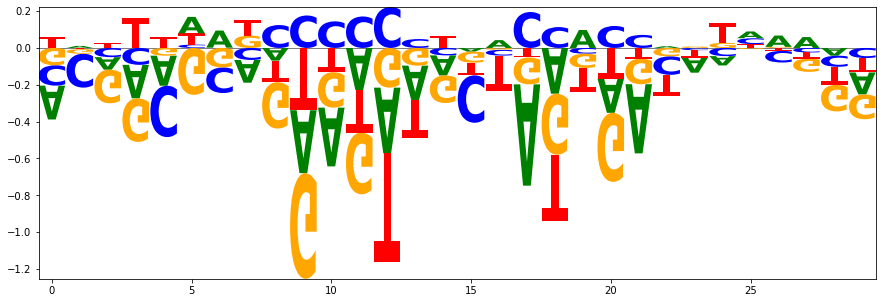





19


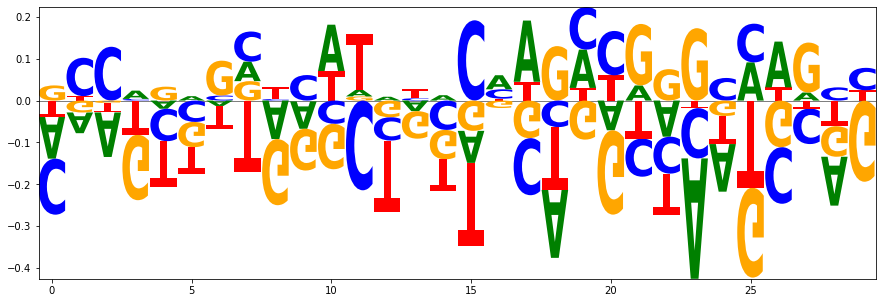

In [38]:
for i in range(pwm_wgts.shape[-1]):
    print(f"\n\n\n\n{i}")
    draw_pwm_filter(pwm_wgts[:,:,i], columns=list("ACTG"))

In my trained network, filter 1 seemed to be a solid PRDM9 motif, let's generate its full image

Computed filter size is 30
Reached example 0
Reached example 1000
Reached example 2000
Reached example 3000
Reached example 4000
Reached example 5000
Consensus: CGACTTCTTTTTAGGACCCCCGTGCCCACC
Degenerate Consensus NNNNNNNNNNNNNNGNCCNCYSYNNCCMCC


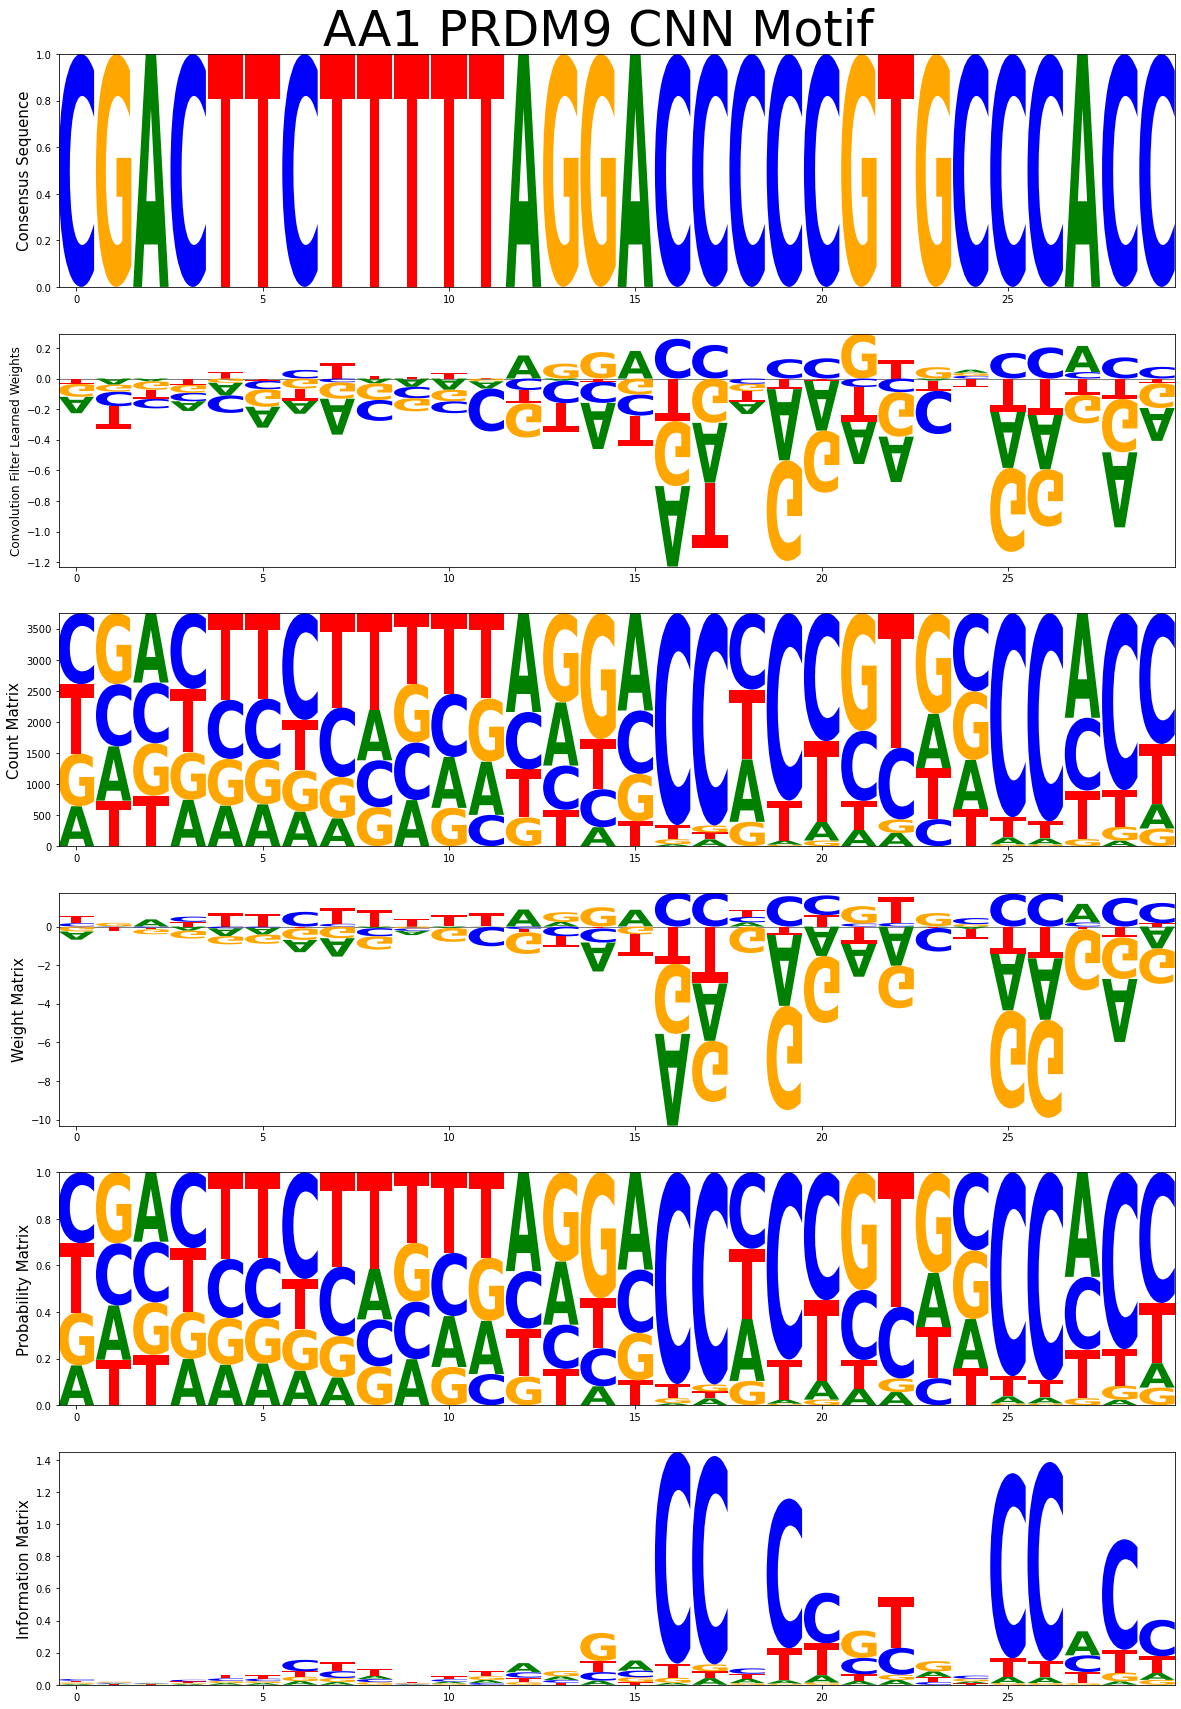

In [39]:
filter_number = 1
interpret_cnn_filter(test2_ds, pwm_wgts, out, filter_number, weblogo_name=None, plt_height=5,
                     title="AA1 PRDM9 CNN Motif")